In [1]:
import numpy as np
import math
from matplotlib import mlab
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy as sp
import random
import networkx as nx
import dwave_networkx as dnx

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from collections import Counter


Сформулируем задачу $QUBO$ для архитерктуры $D-Wave$\
Рассмотрим целевую функцию $f(x) = x^TQx$, $x\in\{0,1\}^s, Q:s*s$

Имеем граф $G = (V, E), n-$вершин\
Гамильтонов цикл интерпретируется как перестановка на $v_0, v_1, \ldots v_{n-1}$ такая, \
что для всех последовательных пар вершин $(v_i, v_{i+1})$ в перестановке $(v_i, v_{i+1})\in E$ \
Нам также требуется $(v_0, v_{n − 1})\in E$, чтобы это был цикл.

Определим вектор
\begin{equation*}
x_{i,j} = 
 \begin{cases}
   1 &\text{$(v_i,v_j)\in E$}\\
   0 &\text{$else$}
 \end{cases}
\end{equation*}
$$i,j\in\{0,1,\ldots n-1\}, т.е. \textbf{x}\in\{0,1\}^{n^2}$$
Определим отображение $vD(\textbf{x}):N\times N\to N, N = \{0, 1,\ldots n-1\} $ \
\
Минимизируемая функция: $F(\textbf{x}) = P_1(\textbf{x}) + P_2(\textbf{x}) + H(\textbf{x}) = \textbf{x}^{T}Q\textbf{x},$
$$P_1(\textbf{x})=\sum^{n-1}_{i=0}(1-\sum^{n-1}_{j=0}x_{i,j})^2, P_2(\textbf{x})=\sum^{n-1}_{j=0}(1-\sum^{n-1}_{i=0}x_{i,j})^2$$
$$H(\textbf{x}) = \sum_{(i_1,i_2)\in V\times V-E(G)}(x_{i_1,0}x_{i_2,n-1}+\sum_{j=0}^{n-2}x_{i_1,j}x_{i_2,j+1}) $$

In [120]:
def show(voc): #По словарю строится граф
    n = len(voc)
    G = nx.DiGraph()
    for i in range(n - 1):
        G.add_edge(voc[i], voc[i+1])
    G.add_edge(voc[n - 1], voc[0])


    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=700 )
    nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=30)  

    plt.axis('off')
    plt.savefig("weighted_graph.png") 
    plt.show()
    return(G) 

def graph(n, k): #Генерация рида и k-меров
    voc = {0:'A', 1:'T', 2:'G', 3:'C'}
    g_read = [0]*n
    
    for i in range(n):
        g_read[i] = voc.get(random.randint(0,3))
    print('read = ', g_read)
    
    t = int(len(g_read) - k + 1)
    
    kmers = [0]*(t)
    
    for i in range(t):
        l = ''
        for j in range(k):
            l = l + g_read[i + j]
            kmers[i] = l
    G = kmers
    print('k-mers = ', G)
    dict = {}
    for i in range(len(G)):
        dict[i] = G[i]
    
    g = show(dict)
    return(dict)

def matrix(voc): #По графу строится матрица смежности
    n = len(voc)
    G = nx.DiGraph()
    for i in range(n - 1):
        G.add_edge(voc[i], voc[i+1])
    G.add_edge(voc[n - 1], voc[0])
    
    adj_matrix = nx.adjacency_matrix(G)
    M = adj_matrix.todense()
    return(M)
    


def adj(M, i1, i2): #Проверка наличия E(i1,i2)
    dict = []

    for j in range(len(M)):
        if M[i1,j] == 1:
            dict.append(j)

    return(i2 in dict)


def generate_qubo(M):    
    varsDict = {}
    n = len(M)
    index = 0
    for i in range(n):
        for j in range(n) :
            varsDict [( i , j ) ] = index
            index += 1
            #print(varsDict)

    Q = {}
    for i in range(n*n):
        for j in range(n*n):
            Q[i, j] = 0
    #p1
    for i in range(n):
        for iprime in range(n) :
            index = varsDict[(i, iprime)]
            Q[index, index] -= 2
            #print(index) 

        for iprime1 in range(n):
            for iprime2 in range(n):
                index1 = varsDict[(i, iprime1)]
                index2 = varsDict[(i, iprime2)]
                Q[index1, index2] += 1
                #print(index1, index2, Q[index1, index2])

    #p2
    for iprime in range(n):
        for i in range(n):
            index = varsDict[(i , iprime)]
            Q[index, index] -= 2
            #print(index, iprime, Q[index, index])

        for i1 in range(n):
            for i2 in range(n):
                index1 = varsDict[(i1, iprime)]
                index2 = varsDict[(i2, iprime)]
                Q[index1, index2] += 1
                #print(index1, index2, Q[index1, index2])

    #f
    for i_1 in range(n):
         for i_2 in range(n):
            if (adj(M, i_1, i_2)) != True and (i_1 != i_2):
                for j in range(n - 1):
                    index_1 = varsDict[i_1, j]
                    index_2 = varsDict[i_2, j + 1]
                    Q[index_1, index_2] += 1
                    #print(j, index_1, index_2, Q[index_1,index_2])
                     
                index_1 = varsDict[i_1, n - 1] 
                index_2 = varsDict[i_2 , 0]

                Q[index_1, index_2 ] += 1
 
    #for i in range(n*n):
    #        for j in range(n*n):
    #            if (i > j) and (not (Q[i, j]==0)):
    #                Q[j, i] += Q [i, j]
    #                Q[i, j] = 0
    return Q, varsDict

def way(Sample, k, vD): #Восстановление путей по цепочки спинов
    x = [0]*k
    vd = list()

    for K in vD.keys(): 
        vd.append(K)
    #print(vd, len(vd))
    
    j = 0
    for i in range(k*k):
        if Sample[i] == 1:
            x[j] = i
            j = j + 1

    d = [0]*k
    for i in range(k):
        d[i] = vd[x[i]][1] 
    return(d)

def genome_way(d, dict): #Восстановление генома по номерам вершин
    genome = []
    for k in range(len(d)): 
        genome.append(dict[d[k]])
    return genome

def delete_repeats(d): #Удаление повторяющихся путей 

    def delete(i, d):
        j = 0
        while j < len(d):
            #print(i, j, len(d) - 1)
            if d[i] == d[j] and i != j:
                del d[j]
            j = j + 1
        return d, len(d)

    i = 0

    while i < len(d):
        d = delete(i, d)[0]
        i = i + 1

    return d    



In [3]:
def dwave(Q, len_M, vD):
    sampler = EmbeddingComposite(DWaveSampler())
    response = sampler.sample_qubo(Q, num_reads=5000)
    d = []
    for sample, energy, occurrences in response.data(['sample', 'energy', 'num_occurrences']): 
        if energy == - len_M*2:
            print("Sample:", sample, "Energy: ", energy, "Occurrences: ", occurrences)
            d.append(way(sample, len_M, vD))
            #print(d)
    return(d)

$\textbf{len_read =  5, 6 - (3-мерами)}$

read =  ['C', 'C', 'A', 'C', 'G']
k-mers =  ['CCA', 'CAC', 'ACG']


d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


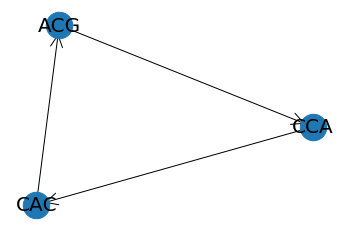

[[0 1 0]
 [0 0 1]
 [1 0 0]]
[-2, 1, 1, 1, 0, 0, 1, 1, 0]
[1, -2, 1, 0, 1, 0, 0, 1, 1]
[1, 1, -2, 0, 0, 1, 1, 0, 1]
[1, 1, 0, -2, 1, 1, 1, 0, 0]
[0, 1, 1, 1, -2, 1, 0, 1, 0]
[1, 0, 1, 1, 1, -2, 0, 0, 1]
[1, 0, 0, 1, 1, 0, -2, 1, 1]
[0, 1, 0, 0, 1, 1, 1, -2, 1]
[0, 0, 1, 1, 0, 1, 1, 1, -2]
{(0, 0): 0, (0, 1): 1, (0, 2): 2, (1, 0): 3, (1, 1): 4, (1, 2): 5, (2, 0): 6, (2, 1): 7, (2, 2): 8}
Sample: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0} Energy:  -6.0 Occurrences:  1886
Sample: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1} Energy:  -6.0 Occurrences:  2528
Sample: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0} Energy:  -6.0 Occurrences:  532
Sample: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0} Energy:  -6.0 Occurrences:  3
Sample: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1} Energy:  -6.0 Occurrences:  2
Sample: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0} Energy:  -6.0 Occurrences:  2
Sample: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 

d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


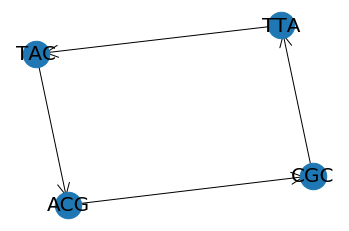

[[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]]
[-2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]
[1, -2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0]
[1, 1, -2, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1]
[1, 1, 1, -2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[1, 1, 0, 0, -2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]
[0, 1, 1, 0, 1, -2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]
[0, 0, 1, 1, 1, 1, -2, 1, 0, 0, 1, 0, 0, 0, 1, 1]
[1, 0, 0, 1, 1, 1, 1, -2, 0, 0, 0, 1, 1, 0, 0, 1]
[1, 1, 0, 0, 1, 1, 0, 0, -2, 1, 1, 1, 1, 0, 0, 0]
[0, 1, 1, 0, 0, 1, 1, 0, 1, -2, 1, 1, 0, 1, 0, 0]
[0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2, 1, 0, 0, 1, 0]
[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2, 0, 0, 0, 1]
[1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, -2, 1, 1, 1]
[0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, -2, 1, 1]
[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2, 1]
[0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2]
{(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3, (1, 0): 4, (1, 1): 5, (1, 2): 6, (1, 3): 7, (2, 0): 8, (2, 1): 9, (2, 2): 10, (2, 3): 11, (3, 0): 12, (3, 1): 

In [135]:
for i in range(5, 7):
    G = graph(i, 3)
    M = matrix(G)
    print(M)
    len_M = len(M)

    qubo = generate_qubo(M)
    Q = qubo[0]
    vD = qubo[1]

    for i in range(len_M*len_M):
        print([Q[i,j] for j in range(len_M*len_M)])

    print(vD)
    d = dwave(Q, len_M, vD)
    delete_repeats(d)
    print(d)

    for i in range(len(d)):
        print('way',i,'=',genome_way(d[i], G))

    

$\textbf{len_read =  7 - (3, 4, 5-мерами)}$

read =  ['C', 'G', 'T', 'G', 'C', 'A', 'C']
k-mers =  ['CGT', 'GTG', 'TGC', 'GCA', 'CAC']


d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


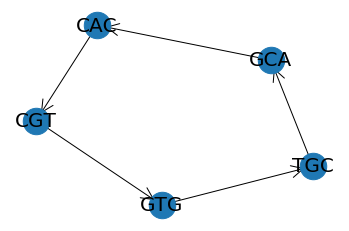

[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[-2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
[1, -2, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
[1, 1, -2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
[1, 1, 1, -2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1]
[1, 1, 1, 1, -2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
[1, 1, 0, 0, 0, -2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
[0, 1, 1, 0, 0, 1, -2, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
[0, 0, 1, 1, 0, 1, 1, -2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
[0, 0, 0, 1, 1, 1, 1, 1, -2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1]
[1, 0, 0, 0, 1, 1, 1, 1, 1, -2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
[1, 1, 0, 0, 0, 1, 1, 0, 0, 0, -2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, -2, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 0, 1, 

In [229]:
G = graph(7, 3)
M = matrix(G)
print(M)
len_M = len(M)

qubo = generate_qubo(M)
Q = qubo[0]
vD = qubo[1]

for i in range(len_M*len_M):
    print([Q[i,j] for j in range(len_M*len_M)])

print(vD)
d = dwave(Q, len_M, vD)


In [228]:
delete_repeats(d)
print(d)

for i in range(len(d)):
    print('way',i,'=',genome_way(d[i], G))

[]


In [154]:
d = []
Sample = {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 1}
d.append(way(Sample, len_M, vD))
Sample = {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 1} 
d.append(way(Sample, len_M, vD))
Sample = {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 1} 
d.append(way(Sample, len_M, vD))
Sample = {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 1} 
d.append(way(Sample, len_M, vD))

d

[[0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4]]

In [202]:
print(d)
for i in range(len(d)):
    print('way',i,'=',genome_way(d[i], G))

[[0, 1, 2, 3, 4]]
way 0 = ['AGA', 'GAA', 'AAG', 'AGG', 'GGC']


In [162]:
delete_repeats(d)
print(d)

for i in range(len(d)):
    print('way',i,'=',genome_way(d[i], G))

[[2, 3, 4, 0, 1]]
way 0 = ['GAA', 'AAG', 'AGC', 'AGG', 'GGA']


read =  ['G', 'C', 'T', 'T', 'G', 'G', 'C']
k-mers =  ['GCTT', 'CTTG', 'TTGG', 'TGGC']


d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


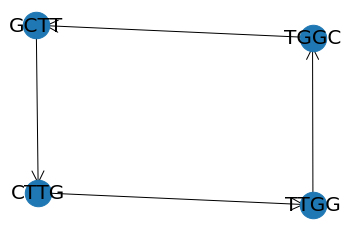

[[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]]
[-2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]
[1, -2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0]
[1, 1, -2, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1]
[1, 1, 1, -2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[1, 1, 0, 0, -2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]
[0, 1, 1, 0, 1, -2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]
[0, 0, 1, 1, 1, 1, -2, 1, 0, 0, 1, 0, 0, 0, 1, 1]
[1, 0, 0, 1, 1, 1, 1, -2, 0, 0, 0, 1, 1, 0, 0, 1]
[1, 1, 0, 0, 1, 1, 0, 0, -2, 1, 1, 1, 1, 0, 0, 0]
[0, 1, 1, 0, 0, 1, 1, 0, 1, -2, 1, 1, 0, 1, 0, 0]
[0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2, 1, 0, 0, 1, 0]
[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2, 0, 0, 0, 1]
[1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, -2, 1, 1, 1]
[0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, -2, 1, 1]
[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2, 1]
[0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2]
{(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3, (1, 0): 4, (1, 1): 5, (1, 2): 6, (1, 3): 7, (2, 0): 8, (2, 1): 9, (2, 2): 10, (2, 3): 11, (3, 0): 12, (3, 1): 

In [211]:
G = graph(7, 4)
M = matrix(G)
print(M)
len_M = len(M)

qubo = generate_qubo(M)
Q = qubo[0]
vD = qubo[1]

for i in range(len_M*len_M):
    print([Q[i,j] for j in range(len_M*len_M)])

print(vD)
d = dwave(Q, len_M, vD)


In [213]:
delete_repeats(d)
print(d)

for i in range(len(d)):
    print('way',i,'=',genome_way(d[i], G))

[[1, 2, 3, 0], [3, 0, 1, 2], [2, 3, 0, 1], [0, 1, 2, 3]]
way 0 = ['CTTG', 'TTGG', 'TGGC', 'GCTT']
way 1 = ['TGGC', 'GCTT', 'CTTG', 'TTGG']
way 2 = ['TTGG', 'TGGC', 'GCTT', 'CTTG']
way 3 = ['GCTT', 'CTTG', 'TTGG', 'TGGC']


read =  ['T', 'C', 'A', 'G', 'C', 'T', 'T']
k-mers =  ['TCAGC', 'CAGCT', 'AGCTT']


d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


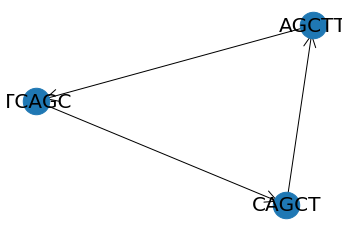

[[0 1 0]
 [0 0 1]
 [1 0 0]]
[-2, 1, 1, 1, 0, 0, 1, 1, 0]
[1, -2, 1, 0, 1, 0, 0, 1, 1]
[1, 1, -2, 0, 0, 1, 1, 0, 1]
[1, 1, 0, -2, 1, 1, 1, 0, 0]
[0, 1, 1, 1, -2, 1, 0, 1, 0]
[1, 0, 1, 1, 1, -2, 0, 0, 1]
[1, 0, 0, 1, 1, 0, -2, 1, 1]
[0, 1, 0, 0, 1, 1, 1, -2, 1]
[0, 0, 1, 1, 0, 1, 1, 1, -2]
{(0, 0): 0, (0, 1): 1, (0, 2): 2, (1, 0): 3, (1, 1): 4, (1, 2): 5, (2, 0): 6, (2, 1): 7, (2, 2): 8}
Sample: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0} Energy:  -6.0 Occurrences:  684
Sample: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1} Energy:  -6.0 Occurrences:  1049
Sample: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0} Energy:  -6.0 Occurrences:  3219
Sample: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0} Energy:  -6.0 Occurrences:  1
Sample: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0} Energy:  -6.0 Occurrences:  2
Sample: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0} Energy:  -6.0 Occurrences:  1
Sample: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 

In [214]:
G = graph(7, 5)
M = matrix(G)
print(M)
len_M = len(M)

qubo = generate_qubo(M)
Q = qubo[0]
vD = qubo[1]

for i in range(len_M*len_M):
    print([Q[i,j] for j in range(len_M*len_M)])

print(vD)
d = dwave(Q, len_M, vD)


In [216]:
delete_repeats(d)
print(d)

for i in range(len(d)):
    print('way',i,'=',genome_way(d[i], G))

[[1, 2, 0], [0, 1, 2], [2, 0, 1]]
way 0 = ['CAGCT', 'AGCTT', 'TCAGC']
way 1 = ['TCAGC', 'CAGCT', 'AGCTT']
way 2 = ['AGCTT', 'TCAGC', 'CAGCT']


$\textbf{len_read =  8 - (3, 4, 5-мерами)}$

read =  ['A', 'C', 'G', 'T', 'C', 'G', 'C', 'G']
k-mers =  ['ACG', 'CGT', 'GTC', 'TCG', 'CGC', 'GCG']


d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


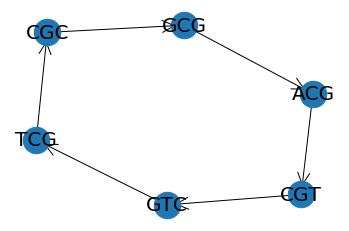

[[0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [1 0 0 0 0 0]]
[-2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
[1, -2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
[1, 1, -2, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]
[1, 1, 1, -2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0]
[1, 1, 1, 1, -2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]
[1, 1, 1, 1, 1, -2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
[1, 1, 0, 0, 0, 0, -2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
[0, 1, 1, 0, 0, 0, 1, -2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
[0, 0, 1, 1, 0, 0, 1, 1, -2, 

In [224]:
G = graph(8, 3)
M = matrix(G)
print(M)
len_M = len(M)

qubo = generate_qubo(M)
Q = qubo[0]
vD = qubo[1]

for i in range(len_M*len_M):
    print([Q[i,j] for j in range(len_M*len_M)])

print(vD)
d = dwave(Q, len_M, vD)


In [225]:
delete_repeats(d)
print(d)

for i in range(len(d)):
    print('way',i,'=',genome_way(d[i], G))

[]


read =  ['T', 'T', 'T', 'C', 'A', 'A', 'T', 'C']
k-mers =  ['TTTC', 'TTCA', 'TCAA', 'CAAT', 'AATC']


d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


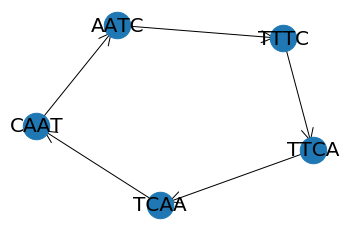

[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[-2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
[1, -2, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
[1, 1, -2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
[1, 1, 1, -2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1]
[1, 1, 1, 1, -2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
[1, 1, 0, 0, 0, -2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
[0, 1, 1, 0, 0, 1, -2, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
[0, 0, 1, 1, 0, 1, 1, -2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
[0, 0, 0, 1, 1, 1, 1, 1, -2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1]
[1, 0, 0, 0, 1, 1, 1, 1, 1, -2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
[1, 1, 0, 0, 0, 1, 1, 0, 0, 0, -2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, -2, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 0, 1, 

In [217]:
G = graph(8, 4)
M = matrix(G)
print(M)
len_M = len(M)

qubo = generate_qubo(M)
Q = qubo[0]
vD = qubo[1]

for i in range(len_M*len_M):
    print([Q[i,j] for j in range(len_M*len_M)])

print(vD)
d = dwave(Q, len_M, vD)


In [219]:
delete_repeats(d)
print(d)

for i in range(len(d)):
    print('way',i,'=',genome_way(d[i], G))

[[0, 1, 2, 3, 4], [3, 4, 0, 1, 2], [2, 3, 4, 0, 1]]
way 0 = ['TTTC', 'TTCA', 'TCAA', 'CAAT', 'AATC']
way 1 = ['CAAT', 'AATC', 'TTTC', 'TTCA', 'TCAA']
way 2 = ['TCAA', 'CAAT', 'AATC', 'TTTC', 'TTCA']


read =  ['C', 'C', 'T', 'C', 'C', 'C', 'T', 'G']
k-mers =  ['CCTCC', 'CTCCC', 'TCCCT', 'CCCTG']


d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


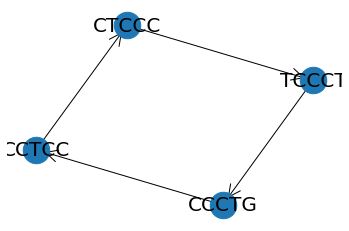

[[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]]
[-2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]
[1, -2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0]
[1, 1, -2, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1]
[1, 1, 1, -2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[1, 1, 0, 0, -2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]
[0, 1, 1, 0, 1, -2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]
[0, 0, 1, 1, 1, 1, -2, 1, 0, 0, 1, 0, 0, 0, 1, 1]
[1, 0, 0, 1, 1, 1, 1, -2, 0, 0, 0, 1, 1, 0, 0, 1]
[1, 1, 0, 0, 1, 1, 0, 0, -2, 1, 1, 1, 1, 0, 0, 0]
[0, 1, 1, 0, 0, 1, 1, 0, 1, -2, 1, 1, 0, 1, 0, 0]
[0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2, 1, 0, 0, 1, 0]
[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2, 0, 0, 0, 1]
[1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, -2, 1, 1, 1]
[0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, -2, 1, 1]
[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2, 1]
[0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2]
{(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3, (1, 0): 4, (1, 1): 5, (1, 2): 6, (1, 3): 7, (2, 0): 8, (2, 1): 9, (2, 2): 10, (2, 3): 11, (3, 0): 12, (3, 1): 

In [220]:
G = graph(8, 5)
M = matrix(G)
print(M)
len_M = len(M)

qubo = generate_qubo(M)
Q = qubo[0]
vD = qubo[1]

for i in range(len_M*len_M):
    print([Q[i,j] for j in range(len_M*len_M)])

print(vD)
d = dwave(Q, len_M, vD)


In [223]:
delete_repeats(d)
print(d)

for i in range(len(d)):
    print('way',i,'=',genome_way(d[i], G))

[[3, 0, 1, 2], [0, 1, 2, 3], [1, 2, 3, 0]]
way 0 = ['CCCTG', 'CCTCC', 'CTCCC', 'TCCCT']
way 1 = ['CCTCC', 'CTCCC', 'TCCCT', 'CCCTG']
way 2 = ['CTCCC', 'TCCCT', 'CCCTG', 'CCTCC']


$\textbf{len_read =  9 - (3, 4, 5-мерами)}$

read =  ['T', 'A', 'A', 'C', 'A', 'G', 'C', 'C', 'T']
k-mers =  ['TAA', 'AAC', 'ACA', 'CAG', 'AGC', 'GCC', 'CCT']


d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


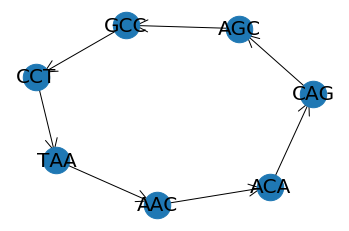

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0]]
[-2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
[1, -2, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
[1, 1, -2, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
[1, 1, 1, -2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
[1, 1, 1, 1, -2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0]
[1, 1, 1, 1, 1, -2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0

In [230]:
G = graph(9, 3)
M = matrix(G)
print(M)
len_M = len(M)

qubo = generate_qubo(M)
Q = qubo[0]
vD = qubo[1]

for i in range(len_M*len_M):
    print([Q[i,j] for j in range(len_M*len_M)])

print(vD)
d = dwave(Q, len_M, vD)


read =  ['T', 'G', 'A', 'A', 'C', 'T', 'A', 'A', 'T']
k-mers =  ['TGAA', 'GAAC', 'AACT', 'ACTA', 'CTAA', 'TAAT']


d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


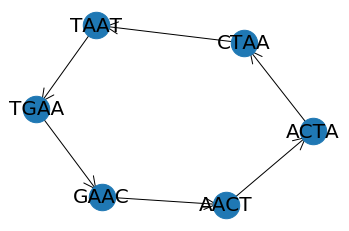

[[0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [1 0 0 0 0 0]]
[-2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
[1, -2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
[1, 1, -2, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]
[1, 1, 1, -2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0]
[1, 1, 1, 1, -2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]
[1, 1, 1, 1, 1, -2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
[1, 1, 0, 0, 0, 0, -2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
[0, 1, 1, 0, 0, 0, 1, -2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
[0, 0, 1, 1, 0, 0, 1, 1, -2, 

In [232]:
G = graph(9, 4)
M = matrix(G)
print(M)
len_M = len(M)

qubo = generate_qubo(M)
Q = qubo[0]
vD = qubo[1]

for i in range(len_M*len_M):
    print([Q[i,j] for j in range(len_M*len_M)])

print(vD)
d = dwave(Q, len_M, vD)
